In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pathlib
import glob
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
train_img_path = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Sign-Language-Detection/data/American Sign Language Letters.v1-v1.voc/new_train_imgs")
train_annot_path = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Sign-Language-Detection/data/American Sign Language Letters.v1-v1.voc/new_train_annot")
test_img_path = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Sign-Language-Detection/data/American Sign Language Letters.v1-v1.voc/new_test_imgs")
test_annot_path = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Sign-Language-Detection/data/American Sign Language Letters.v1-v1.voc/new_test_annot")

train_images = sorted(glob.glob(os.path.join(train_img_path, "*.jpg")))
train_annotations = sorted(glob.glob(os.path.join(train_annot_path, "*.xml")))
test_images = sorted(glob.glob(os.path.join(test_img_path, "*.jpg")))
test_annotations = sorted(glob.glob(os.path.join(test_annot_path, "*.xml")))

In [4]:
train_df = pd.read_pickle("./data/train_df.pkl")
test_df = pd.read_pickle("./data/test_df.pkl")

### Function to Isolate Hand

I created a quick function here to build the base logic for taking in a hand image path, looking at the train_df for its bounding box, and returning an adjusted image with only the pixels that are within the bounding box. 

In [5]:
def isolate_hand(img_name):
    df_entry = train_df[train_df['Image'] == img_name]
    idx = df_entry.index[0]
    img_path = train_images[idx]
    
    img = cv2.imread(img_path)
    xmin, xmax, ymin, ymax = df_entry['Bounding_Box'].values[0]
    
    b_img = img[ymin:ymax, xmin:xmax]
    
    return b_img

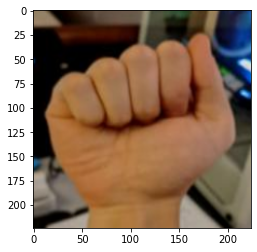

In [6]:
b_img = isolate_hand("A1_1.jpg")
b_img = cv2.resize(b_img, (224,224))

plt.imshow(cv2.cvtColor(b_img, cv2.COLOR_BGR2RGB))

In [7]:
b_img.shape

(224, 224, 3)

### Preprocessing Data into Arrays

#### Prepping Training Data

In [8]:
train_image_arrays = []

for idx, path in enumerate(train_images):
    df_entry = train_df.iloc[idx]
    img = cv2.imread(path)
    
    xmin, xmax, ymin, ymax = df_entry['Bounding_Box']
    b_img = img[ymin:ymax, xmin:xmax]
    b_img = cv2.resize(b_img, (224,224))
    
    train_image_arrays.append(b_img)
    

In [9]:
train_data = []
for array in train_image_arrays:
    prep_array = preprocess_input(array)
    train_data.append(prep_array)
train_data = np.array(train_data)

In [10]:
train_data.shape

(1512, 224, 224, 3)

In [11]:
train_labels = train_df['Letter']

In [12]:
lb = LabelEncoder()
train_labels = lb.fit_transform(train_labels)
train_labels = to_categorical(train_labels)
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [13]:
lb.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype=object)

#### Prepping Validation Data

In [14]:
test_image_arrays = []

for idx, path in enumerate(test_images):
    df_entry = test_df.iloc[idx]
    img = cv2.imread(path)
    
    xmin, xmax, ymin, ymax = df_entry['Bounding_Box']
    b_img = img[ymin:ymax, xmin:xmax]
    b_img = cv2.resize(b_img, (224,224))
    
    test_image_arrays.append(b_img)
    

In [15]:
len(test_image_arrays)

72

In [16]:
test_data = []
for array in test_image_arrays:
    prep_array = preprocess_input(array)
    test_data.append(prep_array)
test_data = np.array(test_data)

In [17]:
test_data.shape

(72, 224, 224, 3)

In [18]:
test_labels = test_df['Letter']

In [19]:
test_labels = lb.transform(test_labels)
test_labels = to_categorical(test_labels)
test_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [20]:
test_data.shape

(72, 224, 224, 3)

In [22]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    # horizontal_flip=True,
    fill_mode="nearest")

In [49]:
aug = ImageDataGenerator(
    rotation_range=45,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=(0.5,1.6),
    fill_mode='nearest'
)


### Modeling

In [59]:
IMG_SHAPE = (224, 224, 3)

In [60]:
mobilenet = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# mobilenet = MobileNetV3Large(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [61]:
handModel = mobilenet.output
# handModel = AveragePooling2D(pool_size=(4, 4))(handModel)
handModel = GlobalAveragePooling2D()(handModel)

handModel = Flatten(name="flatten")(handModel)
handModel = Dense(2014, activation="relu")(handModel)
handModel = Dropout(0.5)(handModel)

# handModel = Dense(256, activation="relu")(handModel)
# handModel = Dense(512, activation = 'relu')(handModel)

# handModel = Dropout(0.5)(handModel)

handModel = Dense(26, activation="softmax")(handModel)

In [62]:
model = Model(inputs=mobilenet.input, outputs=handModel)

for layer in mobilenet.layers:
    layer.trainable = False

In [63]:
# compile our model
opt = Adam(learning_rate=0.001, weight_decay=0.1)
# opt = SGD(momentum=0.9, learning_rate=0.005, weight_decay=0.0005)

model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy", Precision()])

# train the head of the network
history = model.fit(
   aug.flow(train_data, train_labels, batch_size=12), epochs=50,
    validation_data=(test_data, test_labels),
    validation_steps=72/12
)

Epoch 1/50
126/126 [==============================] - 29s 211ms/step - loss: 2.5628 - accuracy: 0.3327 - precision_8: 0.5613 - val_loss: 1.5278 - val_accuracy: 0.5556 - val_precision_8: 0.9091
Epoch 2/50
126/126 [==============================] - 30s 234ms/step - loss: 1.3194 - accuracy: 0.5985 - precision_8: 0.7762 - val_loss: 1.5425 - val_accuracy: 0.5556 - val_precision_8: 0.6667
Epoch 3/50
126/126 [==============================] - 31s 248ms/step - loss: 1.0433 - accuracy: 0.6700 - precision_8: 0.7983 - val_loss: 1.2445 - val_accuracy: 0.6667 - val_precision_8: 0.7115
Epoch 4/50
126/126 [==============================] - 32s 250ms/step - loss: 0.8658 - accuracy: 0.7288 - precision_8: 0.8338 - val_loss: 1.1832 - val_accuracy: 0.6389 - val_precision_8: 0.7358
Epoch 5/50
126/126 [==============================] - 31s 246ms/step - loss: 0.7589 - accuracy: 0.7593 - precision_8: 0.8493 - val_loss: 1.1329 - val_accuracy: 0.7222 - val_precision_8: 0.8113
Epoch 6/50
126/126 [===============

KeyboardInterrupt: 

Best:
- datagen: horizontal_flip: True, zoom_range: 0.1, 
- opt: adam(weight_decay = 0.2)
- Acc: 0.55 in 5 epochs

In [117]:
model.save('model_3.h5')

### Testing Saved Model

In [ ]:
l_model = load_model('model_1.h5')

In [ ]:
l_preds = np.where(l_model.predict(test_data) > 0.5, 1, 0)

3/3 [==============================] - 1s 252ms/step


In [ ]:
l_preds[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

### Setting Up Prediction

In [24]:
model = load_model('model_1.h5')

In [32]:
test_df

,Image,Path,"Dimensions (W,H)",Bounding_Box,xmin,xmax,ymin,ymax,Letter
0,A22_1.jpg,./new_test_imgs/A22_1.jpg,"(416, 416)","[87, 337, 103, 302]",87,337,103,302,A
1,B14_2.jpg,./new_test_imgs/B14_2.jpg,"(416, 416)","[130, 289, 102, 332]",130,289,102,332,B
2,B15_3.jpg,./new_test_imgs/B15_3.jpg,"(416, 416)","[101, 329, 70, 354]",101,329,70,354,B
3,B19_1.jpg,./new_test_imgs/B19_1.jpg,"(416, 416)","[81, 299, 25, 349]",81,299,25,349,B
4,C17_2.jpg,./new_test_imgs/C17_2.jpg,"(416, 416)","[56, 339, 110, 342]",56,339,110,342,C
...,...,...,...,...,...,...,...,...,...
67,Y5_2.jpg,./new_test_imgs/Y5_2.jpg,"(416, 416)","[44, 262, 142, 271]",44,262,142,271,Y
68,Z16_3.jpg,./new_test_imgs/Z16_3.jpg,"(416, 416)","[50, 217, 253, 369]",50,217,253,369,Z
69,Z18_1.jpg,./new_test_imgs/Z18_1.jpg,"(416, 416)","[123, 251, 228, 314]",123,251,228,314,Z
70,Z27_2.jpg,./new_test_imgs/Z27_2.jpg,"(416, 416)","[58, 239, 251, 367]",58,239,251,367,Z


In [33]:
preds_prob = model.predict(test_data)

3/3 [==============================] - 2s 244ms/step


In [82]:
preds_prob.shape

(72, 26)

In [35]:
test_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [85]:
preds = np.empty(shape = (26,))
for row in preds_prob:
    preds = np.vstack((preds, np.where(row == max(row), 1, 0)))
preds = preds[1:]

In [86]:
preds.shape

(72, 26)

In [89]:
from sklearn.metrics import accuracy_score, precision_score
accuracy_score(preds, test_labels)
# precision_score(preds, test_labels)

0.7222222222222222

In [97]:
lb.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype=object)

In [98]:
letters = lb.classes_

In [102]:
preds_prob[0]

array([9.93613541e-01, 6.67142158e-05, 8.06639582e-05, 3.34963697e-05,
       1.36000468e-04, 1.77999464e-04, 1.01229314e-04, 3.72114073e-06,
       2.93489961e-06, 1.04429637e-04, 2.51189590e-07, 1.32437947e-07,
       2.29631733e-05, 4.02576006e-05, 1.96199238e-04, 5.07482991e-06,
       3.08046560e-06, 1.68777703e-08, 4.24637878e-03, 1.15375104e-03,
       7.49464206e-08, 6.45742793e-10, 2.76168111e-09, 1.15964940e-06,
       4.79860682e-06, 5.12028373e-06], dtype=float32)

In [103]:
[np.log(pred) for pred in preds_prob[0]]

[-0.0064069396,
 -9.615092,
 -9.425219,
 -10.304073,
 -8.902852,
 -8.63373,
 -9.198122,
 -12.50148,
 -12.738837,
 -9.166997,
 -15.197058,
 -15.837152,
 -10.681619,
 -10.120212,
 -8.53638,
 -12.191217,
 -12.69043,
 -17.897268,
 -5.4616885,
 -6.764737,
 -16.406492,
 -21.16062,
 -19.707426,
 -13.667393,
 -12.247185,
 -12.182301]

In [100]:
np.argmax(preds_prob[0])

0

In [101]:
letters[np.argmax(preds_prob[0])]

'A'